In [242]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
import sci.learn as sci
import sci.plots as scip


import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [243]:
# raw data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

train_df = df_train
test_df = df_test

## Starts

In [244]:
scif.normalize_feature_names(df_train, df_test)
# switch target price to log scale, it's more normal and scoring is easier for rmsle
# df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

## Normalize Target

In [245]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [246]:
# from sklearn.preprocessing import QuantileTransformer
# y_tr = QuantileTransformer(output_distribution='normal')
# df_train['SalePrice'] = y_tr.fit_transform(df_train[['SalePrice']])[:, 0]

In [247]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# lam = boxcox_normmax(df_train['SalePrice'])
# df_train['SalePrice'] = boxcox1p(df_train['SalePrice'], lam)

# print(f'optimal lambda: {lam}')

## Drop outliers from train data

### Manual outlier handling

In [248]:
# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
df_train.drop(df_train[df_train["GrLivArea"] > 4000].index, inplace=True)

### Automatic outlier handling

## Clean Data Types

In [249]:
# columsn with more than one data type (excluding NaN values)
display(scif.types_of_df(df_train, more_than_one=True))
display(scif.types_of_df(df_test, more_than_one=True))

,types,n_types


,types,n_types


## Missing Values
- drop columns with mostly missing values: these might have very little value for generalization
- columns with few missing values: we can drop the samples, or impute them. Dropping is only possible for the train_set, we can't drop from the live scoring set
- we can drop samples with missing values, but that isn't a good option when we don't have many samples, plus they can be special cases which we do want to model
- we can impute (fill) missing values, this makes sense sometimes, but not always as sometimes:
- missing values can represent a special "state", like value is missing since for this sample it's irrelevant. Filling this value would be incorrect.

### Manual

In [250]:
# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = 1980

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test_df.loc[1116, "GarageType"] = np.nan
test_df.loc[1116, "GarageArea"] = 0
test_df.loc[1116, "GarageCars"] = 0
test_df.loc[1116, "GarageYrBlt"] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median LotFrontage of the neighborhood.
# Note that we use the "train" values to also fill the "test" values
lot_frontage_by_neighborhood = train_df.groupby("Neighborhood")["LotFrontage"].median()

### encoding string features:
- opt-1: pd.factorize() and sklearn.LabelEncoder(): convert a single string feature to a single int features by mapping each label value to a number (and remember the mapping for later use)
- opt-2: pd.get_dummies() and sklearn.OneHotEncoder(): convert a single string feature to many bool features, 1-per label value
- note: get_dummies also supports drop_first which helps reduce dimensions and colinearity
but to be 100% sure we don't have different dummies between what the model expects (train) and test, we should use OneHotEncoder


## Main Processing

In [251]:
def process(df):
    
    # Fill LotFrontage based on median LotFrontage by Neighborhood
    # we could do it based on the data in the given DF
    # but the more correct way is to use the train data
    # df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) 
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(lot_frontage_by_neighborhood[x.name])) 
    
    # fill NA with '0'
    cols = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']
    df[cols] = df[cols].fillna(0)
    
    # fill NA with median
    cols = ['GarageYrBlt', ]
    df[cols] = df[cols].transform(lambda x: x.fillna(x.median()))
    
    # fill NA with mode
    cols = ['MSZoning', ]
    df[cols] = df[cols].transform(lambda x: x.fillna(x.mode()[0]))
    
    
    fmap = """20	1-STORY 1946 & NEWER ALL STYLES
    30	1-STORY 1945 & OLDER
    40	1-STORY W/FINISHED ATTIC ALL AGES
    45	1-1/2 STORY - UNFINISHED ALL AGES
    50	1-1/2 STORY FINISHED ALL AGES
    60	2-STORY 1946 & NEWER
    70	2-STORY 1945 & OLDER
    75	2-1/2 STORY ALL AGES
    80	SPLIT OR MULTI-LEVEL
    85	SPLIT FOYER
    90	DUPLEX - ALL STYLES AND AGES
    120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
    150	1-1/2 STORY PUD - ALL AGES
    160	2-STORY PUD - 1946 & NEWER
    180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
    190	2 FAMILY CONVERSION - ALL STYLES AND AGES"""

    fmap = [x.split('\t') for x in fmap.split('\n')]
    fmap = dict((int(x[0]), x[1]) for x in fmap)
    df['MSSubClass_'] = df['MSSubClass'].apply(lambda x: fmap[x])    
    
    df['is_PUD'] = df['MSSubClass_'].str.contains("PUD")
    # we already have Duplex and 2-family-conv covered in BldgType
#     df['is_Duplex'] = df['MSSubClass_'].str.startswith("DUPLEX")
#     df['is_2FamConv'] = df['MSSubClass_'].str.startswith("2 FAMILY CONVERSION")
    df.drop(['MSSubClass', 'MSSubClass_'], axis=1, inplace=True)

    
    # stories feature
    # we have two features indicating num of stories, some of them are conflicting, and some don't have exact story count
#     display(pd.crosstab(df['MSSubClass'], df['HouseStyle']))
    # we use the HouseStyle feature to deduce exact floors count, and keep np.nan when it's unclear
    # the nan values will be filled later on with the final imputation
    fmap = {'1Story': 1, '1.5Fin': 1.5, '1.5Unf': 1.5, '2Story': 2, '2.5Fin': 2.5, '2.5Unf': 2.5, 'SFoyer': np.nan, 'SLvl': np.nan}
    df['floors'] = df['HouseStyle'].apply(lambda x: fmap[x])
    df['is_split_floor'] = (df['HouseStyle'] == 'SFoyer') | (df['HouseStyle'] == 'SLvl')
    df['is_unfinished'] = df['HouseStyle'].str.endswith("Unf")
    # we then drop the HouseStyle which is no longer needed
    df.drop('HouseStyle', axis=1, inplace=True)

    df['is_residential'] = df['MSZoning'].isin(set(['FV', 'RH', 'RL', 'RP', 'RM']))
    fmap = {np.nan: 0, 'A': 0, 'C (all)': 0, 'I': 0, 'FV': 1, 'RP': 2, 'RL': 3, 'RM': 4, 'RH': 5}
    df['residential_density'] = df['MSZoning'].apply(lambda x: fmap[x])
    df.drop('MSZoning', axis=1, inplace=True)
    
    cond1 = pd.get_dummies(df[['Condition1']], columns=['Condition1'], prefix="Condition")
    cond2 = pd.get_dummies(df[['Condition2']], columns=['Condition2'], prefix="Condition")
    df = df.join(cond1|cond2)
    df.drop(['Condition1', 'Condition2'], axis=1, inplace=True)
    
    part1 = pd.get_dummies(df[['Exterior1st']], columns=['Exterior1st'], prefix="Exterior")
    part2 = pd.get_dummies(df[['Exterior2nd']], columns=['Exterior2nd'], prefix="Exterior")
    df = df.join(part1|part2)
    df.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)
    # hack fix for Exterior_Other in train but not test:
    if not 'Exterior_Other' in df.columns:
        df['Exterior_Other'] = 0
    
    df["has_shed"] = df['MiscFeature'] == 'Shed'
    df.drop(['MiscFeature'], axis=1, inplace=True)
    
    df["sale_new"] = df['SaleType'] == 'New'
    df["sale_court"] = df['SaleType'] == 'COD'
    df["sale_deed"] = df['SaleType'].isin(['WD', 'CWD', 'VWD'])
    df.drop(['SaleType'], axis=1, inplace=True)
    
    df['decade_built'] = (df['YearBuilt']/10).astype(int)*10
#     df.drop(['YearBuilt'], axis=1, inplace=True)
    # should we drop YearBuilt?
    df['decade_remode'] = (df['YearRemodAdd']/10).astype(int)*10
#     df.drop(['YearRemodAdd'], axis=1, inplace=True)
    # should we drop YearRemodAdd?

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    scif.from_cat_to_numeric(df, "Alley", 'NA,Grvl,Pave', 'NA')
    scif.from_cat_to_numeric(df, "LotShape", 'IR3,IR2,IR1,Reg')
    scif.from_cat_to_numeric(df, "LandSlope", 'Gtl,Mod,Sev')
    scif.from_cat_to_numeric(df, "ExterQual", 'Po,Fa,TA,Gd,Ex')
    scif.from_cat_to_numeric(df, "ExterCond", 'Po,Fa,TA,Gd,Ex')
    scif.from_cat_to_numeric(df, "BsmtQual", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "BsmtCond", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "BsmtExposure", 'NA,No,Mn,Av,Gd', 'NA')
    scif.from_cat_to_numeric(df, "BsmtFinType1", 'NA,Unf,LwQ,Rec,BLQ,ALQ,GLQ', 'NA')
    scif.from_cat_to_numeric(df, "BsmtFinType2", 'NA,Unf,LwQ,Rec,BLQ,ALQ,GLQ', 'NA')
    scif.from_cat_to_numeric(df, "HeatingQC", 'Po,Fa,TA,Gd,Ex')
    scif.from_cat_to_numeric(df, "Electrical", 'Mix,FuseP,FuseF,FuseA,SBrkr', np.nan)
    scif.from_cat_to_numeric(df, "KitchenQual", 'Po,Fa,TA,Gd,Ex', np.nan)
    scif.from_cat_to_numeric(df, "Functional", 'Sal,Sev,Maj2,Maj1,Mod,Min2,Min1,Typ', np.nan)
    scif.from_cat_to_numeric(df, "FireplaceQu", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "GarageType", 'NA,CarPort,Basment,2Types,Detchd,Attchd,BuiltIn', "NA")
    scif.from_cat_to_numeric(df, "GarageFinish", 'NA,Unf,RFn,Fin', "NA")
    scif.from_cat_to_numeric(df, "GarageQual", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "GarageCond", 'NA,Po,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "PavedDrive", 'N,P,Y')
    scif.from_cat_to_numeric(df, "PoolQC", 'NA,Fa,TA,Gd,Ex', 'NA')
    scif.from_cat_to_numeric(df, "Fence", 'NA,MnWw,GdWo,MnPrv,GdPrv', 'NA')
    
    
    # one-hot-encode
    # we can auto-encode all 'object' features
    # but if we want to be careful, it's best to add them one by one, and see if we forgot something
    # to_one_hot_encode = df.dtypes[df.dtypes == "object"].index.values 
    to_one_hot_encode = ['BldgType', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'RoofStyle', 'MasVnrType', 'Foundation', 'CentralAir', 'SaleCondition']
    df = pd.get_dummies(df, columns=to_one_hot_encode, drop_first=False, prefix_sep='__')
    
    
    # features to simply drop
    to_drop = ['Utilities', 'RoofMatl', 'Heating']
    df.drop(to_drop, axis=1, inplace=True)
    
    return df
    
    
df_train_proc = process(df_train.copy())
df_test_proc = process(df_test.copy())


In [252]:
# Utility for exploration
# cols = [c for c in df.columns if df[c].dtype == "object"]
# df[cols] = df[cols].fillna('MISSING')

## Switch all to floats

In [253]:
for c in df_train_proc.columns:
    df_train_proc[c] = df_train_proc[c].astype(float)
for c in df_test_proc.columns:
    df_test_proc[c] = df_test_proc[c].astype(float)


## Impute using IterativeImputer

In [254]:
display(scif.df_summary(df_train_proc, missing_only=True))
display(scif.df_summary(df_test_proc, missing_only=True))

,count,missing,percent,dtype,types,uniq,miss-idx,values,freq
floors,1354,102,7.0055,float64,float,4,"42, 54, 75","1.0, 1.5, 2.0, 2.5","'1.0':726, '2.0':441, '1.5':168, '2.5':19..."
Electrical,1455,1,0.0687,float64,float,5,1379,"0.0, 1.0, 2.0, 3.0, 4.0","'4.0':1330, '3.0':94, '2.0':27, '1.0':3, '0..."


,count,missing,percent,dtype,types,uniq,miss-idx,values,freq
floors,1350,109,7.4709,float64,float,4,"24, 52, 56","1.0, 1.5, 2.0, 2.5","'1.0':745, '2.0':427, '1.5':165, '2.5':13..."
Functional,1457,2,0.1371,float64,float,7,"756, 1013","1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0","'7.0':1357, '5.0':36, '6.0':34, '4.0':20, '..."
KitchenQual,1458,1,0.0685,float64,float,4,95,"1.0, 2.0, 3.0, 4.0","'2.0':757, '3.0':565, '4.0':105, '1.0':31..."


In [255]:
# we are specific on the columns just to be sure we didn't miss anything
cols_to_impute = ['floors', 'Electrical', 'Functional', 'KitchenQual']
scif.impute_iterative(df_train_proc, columns=cols_to_impute)
scif.impute_iterative(df_test_proc, columns=cols_to_impute)

In [256]:
scif.assert_no_missing_values(df_train_proc)
scif.assert_no_missing_values(df_test_proc)

### check and reduce skewness

In [257]:
scif.skewness_check(df_train_proc).head(10)

,Skew
Exterior_CBlock,38.1182
Exterior_BrkComm,26.9258
Condition_RRNe,26.9258
Neighborhood__Blueste,26.9258
RoofStyle__Shed,26.9258
MiscVal,24.4182
Foundation__Wood,21.9621
Exterior_AsphShn,21.9621
PoolQC,21.1287
SaleCondition__AdjLand,19.0001


In [258]:
# scif.skewness_fix(df_train_proc)

In [259]:
scif.skewness_check(df_train_proc).head(10)

,Skew
Exterior_CBlock,38.1182
Exterior_BrkComm,26.9258
Condition_RRNe,26.9258
Neighborhood__Blueste,26.9258
RoofStyle__Shed,26.9258
MiscVal,24.4182
Foundation__Wood,21.9621
Exterior_AsphShn,21.9621
PoolQC,21.1287
SaleCondition__AdjLand,19.0001


## Categorical Features
- text features with few values are classic categorical features
- text features with rich content are NOT
- numeric (integer) features with few values that represent categories can be treated as categorical, but can also be processed as numeric and let the model figure it out

What do we do with them?
- we can convert them to integers using LabelEncoder and let the model figure it out
- we can convert them to one-hot features using get_dummie or OneHotEncoder

TODO:  
solved with (drop_first=True) ?  
https://www.algosome.com/articles/dummy-variable-trap-regression.html

## Drop Outliers

In [260]:
from sklearn.linear_model import *

X = df_train_proc.drop('SalePrice', axis=1)
y = df_train_proc['SalePrice']
model = RidgeCV()
model.fit(X, y)
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X, y, scoring=rmse_score).mean()

y_pred = pd.Series(model.predict(X), index=y.index)
y_resid = y - y_pred
resid_mean = y_resid.mean()
resid_std  = y_resid.std()
resid_z = (y_resid - resid_mean) / resid_std
outliers_idx = y.index[np.abs(resid_z) >= 3]

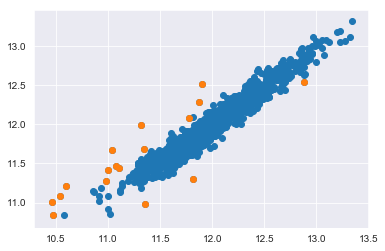

In [261]:
plt.scatter(y, y_pred)
plt.scatter(y.loc[outliers_idx], y_pred.loc[outliers_idx])

In [262]:
df_train_proc = df_train_proc.drop(outliers_idx)

## Finished

In [263]:
scif.df_comp(df_train_proc.drop(["SalePrice"], axis=1), df_test_proc, "train", "test")


has NaN mismatch train vs test:

has NaN mismatch test vs train:

dtype mismatch:

unique categorical values mismatch in train:

unique categorical values mismatch in test:


## Split data

In [264]:
X_train = df_train_proc.set_index("Id")
y = X_train['SalePrice']
X_train = X_train.drop('SalePrice', axis=1)

X_score = df_test_proc.set_index("Id")

print(X_train.shape, y.shape, X_score.shape)

(1439, 163) (1439,) (1459, 163)


## Save

In [265]:
path = 'processed_my'
!mkdir -p $path
X_train.to_msgpack(f'{path}/X.msgpack')
y.to_msgpack(f'{path}/y.msgpack')
X_score.to_msgpack(f'{path}/X_score.msgpack')

from sklearn.externals import joblib
joblib.dump(y_tr, f'{path}/y_tr.joblib')


['processed_my/y_tr.joblib']

## Quick Test

In [266]:
import sklearn.utils
from sklearn.linear_model import *
import sci

In [267]:
path = 'processed_my'
import xgboost

# model = ElasticNetCV(l1_ratio=0.5)
model = xgboost.XGBRegressor()

data = sci.load_data(path)
cv_scores = sci.score_cv(data, model, rmse_score, verbose=2, cv=10)

(1439, 163) (1439,)
CV for XGBRegressor ..


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 out of  10 | elapsed:    6.3s remaining:    2.7s
[Parallel(n_jobs=11)]: Done  10 out of  10 | elapsed:    6.4s finished


,mean,std
XGBRegressor,0.1069,0.0039


Can't plot with only a single or no samples
